In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from nltk.corpus import stopwords
from string import punctuation

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
content = pd.read_csv("./SpamDitection/SMSSpamCollection",sep="\t",names=['spam','message'])

In [6]:
print(content.head(n=5))

   spam                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [7]:
classnames = ['ham','spam']
#  'ham'  -> 0
#  'spam' ->1

In [8]:
content.spam = content.spam.apply(lambda classname : classnames.index(classname))

In [9]:
content.head(n=5)

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


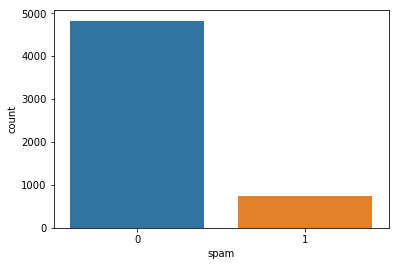

In [10]:
sns.countplot(x='spam',data=content)

In [11]:
print("Shape of messages : %s"%str(content.shape))

Shape of messages : (5572, 2)


In [12]:
print("Total no of spam messages : %s"%str(content[content['spam']==1].shape))

Total no of spam messages : (747, 2)


<h1>Text Preprocessing</h1>

In [13]:
stopword = stopwords.words('english')
print("First 10 stopwords : %s"%str(stopword[:10]))

msg = 'Sample message! Notice: it has punctuation.'

print(msg)
msg = ''.join([i for i in msg if i not in punctuation])
print(msg)
msg = msg.split(" ")
msg = " ".join([i for i in msg if i not in stopword])
print(msg)

First 10 stopwords : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Sample message! Notice: it has punctuation.
Sample message Notice it has punctuation
Sample message Notice punctuation


In [99]:
def text_preprocessing(msg,stopword=stopword,punctuation=punctuation):
    msg = ''.join([i for i in msg if i not in punctuation])
    msg = msg.split(" ")
    msg = " ".join([i for i in msg if i.lower() not in stopword])
    return msg

In [100]:
text_preprocessing('Sample message! Notice: it has punctuation.')

'Sample message Notice punctuation'

In [101]:
content.message[0]

'Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat'

In [102]:
content.message = content.message.apply(text_preprocessing)

In [103]:
print("String after preprocessing : %s"%content.message[0])

String after preprocessing : Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat


### Data Visualization

In [104]:
content['length'] = content.message.apply(len)

In [105]:
sns.set_style('darkgrid')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B4A91C7518>,
      dtype=object)

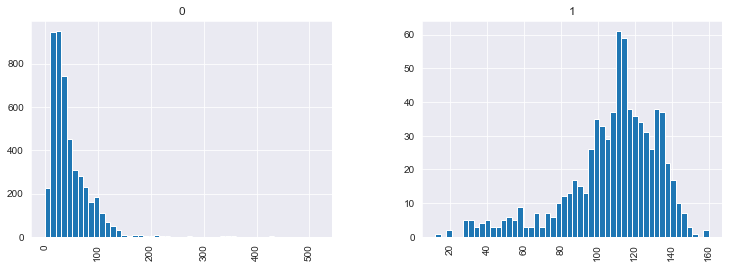

In [106]:
content.hist(column='length', by='spam', bins=50,figsize=(12,4))

In [107]:
content.drop('length',axis=1,inplace=True)

In [108]:
content.head()

,spam,message
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


<h1>Train test split</h1>

In [109]:
def train_test_split(X,y,random_state=42,test_size=0.25):
    m = len(content['message'])
    trainSize = int(m * (1 - test_size))
    
    np.random.seed(random_state)
    random_index = np.random.permutation(m)
    train = random_index[:trainSize]
    test  = random_index[trainSize:]
    
    return np.array(X[train]),np.array(X[test]),np.array(y[train]),np.array(y[test])

In [110]:
X_train,X_test,y_train,y_test = train_test_split(content.message,content.spam,random_state=101)

In [111]:
print("Data Details : ")
print("\nTrain data details : ")
print("===================================")
print("Shape of X_train : %s"%str(X_train.shape))
print("Shape of y_train : %s"%str(y_train.shape))
print("\nTrain data details : ")
print("===================================")
print("Shape of X_test : %s"%str(X_test.shape))
print("Shape of y_test : %s"%str(y_test.shape))

Data Details : 

Train data details : 
Shape of X_train : (4179,)
Shape of y_train : (4179,)

Train data details : 
Shape of X_test : (1393,)
Shape of y_test : (1393,)


<h1>Tokenizer</h1>

In [112]:
vocab_size    = 8000
embedding_dim = 16
oov_token     = "<oov>"
padding       = "post"
maxlen        = 120
truncating    = 'post'

In [113]:
tokenizer1 = Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer1.fit_on_texts(X_train)
word_index = tokenizer1.word_index
seq = tokenizer1.texts_to_sequences(X_train)
pad_seq_train = pad_sequences(seq,maxlen=maxlen,truncating=truncating,padding=padding)     #Training Data

In [114]:
def revdict(Dict):
    D = dict()
    for w,k in Dict.items():
        D[k] = w
    return D

In [115]:
rev_word_index = revdict(word_index)

In [116]:
#rev_word_index

In [117]:
seqTest      = tokenizer1.texts_to_sequences(X_test)
pad_seq_test = pad_sequences(seqTest,maxlen=maxlen,truncating=truncating,padding=padding)     #Testing Data

<h1>Model1</h1>

In [118]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [119]:
model1.compile(optimizer='adam',loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

In [120]:
history1 = model1.fit(pad_seq_train,y_train,epochs=20,validation_data=(pad_seq_test,y_test))

Train on 4179 samples, validate on 1393 samples
Epoch 1/20
4179/4179 [==============================] - 5s 1ms/sample - loss: 0.3801 - acc: 0.8638 - val_loss: 0.3007 - val_acc: 0.8571
Epoch 2/20
4179/4179 [==============================] - 1s 237us/sample - loss: 0.2004 - acc: 0.8866 - val_loss: 0.1742 - val_acc: 0.9361
Epoch 3/20
4179/4179 [==============================] - 1s 240us/sample - loss: 0.1400 - acc: 0.9694 - val_loss: 0.1480 - val_acc: 0.9713
Epoch 4/20
4179/4179 [==============================] - 1s 248us/sample - loss: 0.1140 - acc: 0.9828 - val_loss: 0.1327 - val_acc: 0.9749
Epoch 5/20
4179/4179 [==============================] - 1s 233us/sample - loss: 0.0979 - acc: 0.9897 - val_loss: 0.1243 - val_acc: 0.9763
Epoch 6/20
4179/4179 [==============================] - 1s 264us/sample - loss: 0.0862 - acc: 0.9926 - val_loss: 0.1190 - val_acc: 0.9770s - loss: 0.0832 - 
Epoch 7/20
4179/4179 [==============================] - 1s 247us/sample - loss: 0.0767 - acc: 0.9945 - val_

In [121]:
def loss_acc(history):
    fig,ax = plt.subplots(1,2,figsize=(16,6))

    ax[0].plot(history.history['acc'],label='Training')
    ax[0].plot(history.history['val_acc'],label='Testing')
    ax[0].set_title("Accurecy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Acc")
    ax[0].legend()

    ax[1].plot(history.history['loss'],label='Training')
    ax[1].plot(history.history['val_loss'],label='Testing')
    ax[1].set_title("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

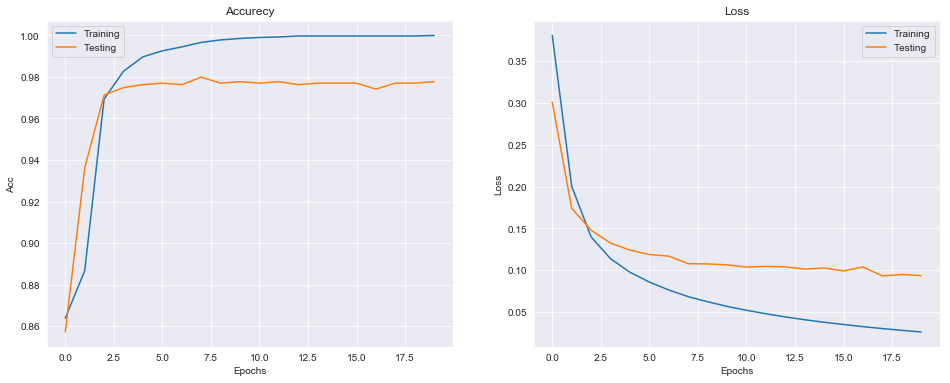

In [122]:
loss_acc(history1)

In [123]:
#X_test[107]

In [124]:
#for i in range(len(y_test)):
#    if y_test[i] == 1:
#        print(i)

In [125]:
#107  137  631

In [126]:
#rev_word_index

In [127]:
import io
out_v = io.open("vecs.tsv","w",encoding='utf-8')
out_m = io.open("meta.tsv","w",encoding='utf-8')

In [128]:
weights = model1.layers[0].get_weights()[0]

In [129]:
weights.shape

(8000, 16)

In [130]:
for word_num in range(1,vocab_size):
    word = rev_word_index[word_num]
    embedding = weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embedding]) + '\n')
out_m.close()
out_v.close()

In [151]:
y_train[48]

1

In [141]:
model1.predict_classes(pad_seq_test[401:402])

array([[1]])

In [133]:
y_test[401]

1

In [137]:
def sen(matrix):
    string = ""
    for i in range(len(matrix)):
        if matrix[i]==0:
            break
        string += rev_word_index[matrix[i]]
        string += " "
    return string

In [153]:
print("'%s' is a : %s"%(sen(pad_seq_test[401]) , classnames[model1.predict_classes(pad_seq_test[401:402])[0,0]]))

'ur hmv quiz cashbalance currently £500 maximize ur cashin send <oov> 86688 150pmsg ' is a : spam
